# dsPCA demo
This demo will apply dsPCA to an example neural population activity recorded from mice performing value-based decision making (Hattori et al., Cell, 2019). We will decompose the population activity into a demixed target value-related subspace (3 target dimensions) and a target-free subspase where the 3 targeted signals are removed.

#### Load modules

In [57]:
from dspca import dsPCA
from sklearn.decomposition import PCA
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from dspca.utils import adjust_lightness

#### Load data

In [ ]:
with np.load(r'C:\Users\Ryoma\PycharmProjects\dspca\data\data.npz') as data:
    dQ = data['dQ']  # Target
    Qch = data['Qch']  # Target
    sQ = data['sQ']  # Target
    activity = data['activity']  # Neural population activity (Trial X Time X Cell)

#### Set parameters

In [ ]:
targets = np.vstack((dQ, Qch, sQ)).T    # Target task-related variables
time_range = np.arange(10, 15)  # Time range used to identify subspaces
activity_mean = np.mean(activity[:, time_range, :], axis=1)  # Temporally averaged neural population activity (Trial X Cell)

#### Run dsPCA

In [ ]:
projection_target_subspace, projection_targetfree_subspace, ax_targets, ax_targetfree, \
target_subspace_signal, targetfree_subspace_signal, target_subspace_var, targetfree_subspace_var, total_var, dot_target_ax\
    = dsPCA(data=activity_mean, targets=targets)

projection_target_subspace
- Projections of population activity to demixed target signal axes ([Trials] x [target dimensions]). The dimension type is in the order of dQ, Qch, sQ.

projection_targetfree_subspace
- Projections of population activity to the axes of target-free subspace ([Trials] x [target-free dimensions]). The dimensions are ordered according to the amount of explained activity variance.

ax_targets
- Axis vectors for the target signal subspace.

ax_targetfree
- Axis vectors for the target-free signal subspace.

target_subspace_signal
- Pearson correlation coefficient between the activity along each target axis and the targeted task-related variables. The 1st dimension indicates target axis type, the 2nd dimension indicates target variables, the 3rd dimension specifies the correlation coefficient (0) or the p-value (1).

targetfree_subspace_signal
- Pearson correlation coefficient between the activity along each target-free axis and the targeted task-related variables. The 1st dimension indicates target-free axes, the 2nd dimension indicates target variables, the 3rd dimension specifies the correlation coefficient (0) or the p-value (1).

target_subspace_var
- Activity variance along each taraget axis

targetfree_subspace_var
- Activity variance along each taraget-free axis

total_var
- Total activity variance of the original input data (activity_mean)

dot_target_ax
- Matrix with dot products between pairs of target axis vectors.

#### Project original Trial X Time X Cell tensor to a target subspace and a target-free subspace

In [ ]:
projection_target_subspace_3d = np.matmul(activity, ax_targets)
projection_targetfree_subspace_3d = np.matmul(activity, ax_targetfree)

#### Dimensions that capture the largest within-trial temporal data variance within the target-free subspace

In [ ]:
pc_num = 2  # Number of dimensions for temporal axes
pca_time = PCA(n_components=pc_num)
pca_time.fit(np.mean(projection_targetfree_subspace_3d, axis=0))
projection_targetfree_subspace_temporal = np.matmul(projection_targetfree_subspace_3d, pca_time.components_.T)

#### Binning of projected activity according to dQ values

In [ ]:
bin_width = 0.1
projection_target_subspace_temporal_binned = np.zeros((int(2/bin_width), 38, 3))
projection_targetfree_subspace_temporal_binned = np.zeros((int(2/bin_width), 38, 2))
for bin_id in range(int(2/bin_width)):
    projection_target_subspace_temporal_binned[bin_id, :, :] = np.mean(projection_target_subspace_3d[(dQ >= -1 + (bin_id * bin_width)) & (dQ <= -0.9 + (bin_id * bin_width)), :, :], axis=0)
    projection_targetfree_subspace_temporal_binned[bin_id, :, :] = np.mean(projection_targetfree_subspace_temporal[(dQ >= -1 + (bin_id * bin_width)) & (dQ <= -0.9 + (bin_id * bin_width)), :, :], axis=0)


#### Plot the population activity in a neural subspace

C:\Users\Ryoma\Anaconda3\envs\dspca\lib\site-packages\ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  This is separate from the ipykernel package so we can avoid doing imports until


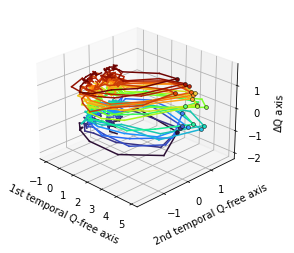

In [60]:
%matplotlib inline
fig = plt.figure()
ax = fig.gca(projection='3d')
min_lightness = 0.9
max_lightness = 0.9
N = 38 - 1
for dq_ind in range(20):
    for time_id in range(N):
        ax.plot(projection_targetfree_subspace_temporal_binned[dq_ind, time_id:time_id + 2, 0], projection_targetfree_subspace_temporal_binned[dq_ind, time_id:time_id + 2, 1], projection_target_subspace_temporal_binned[dq_ind, time_id:time_id + 2, 0], color=adjust_lightness(matplotlib.cm.get_cmap('turbo')(dq_ind / 19), min_lightness + (max_lightness - min_lightness) * ((N - time_id) / N)), linewidth=1.5, alpha=1)
    ax.scatter(projection_targetfree_subspace_temporal_binned[dq_ind, 19, 0], projection_targetfree_subspace_temporal_binned[dq_ind, 19, 1], projection_target_subspace_temporal_binned[dq_ind, 19, 0], color=matplotlib.cm.get_cmap('turbo')(dq_ind / 19), edgecolors='k', linewidths=0.5, marker='o', s=15)
ax.set_xlabel('1st temporal Q-free axis')
ax.set_ylabel('2nd temporal Q-free axis')
ax.set_zlabel('$\Delta$Q axis')
ax.view_init(25, -45)
plt.show()
